# Sampling and Model Interpretability

In [1]:
!pip install pulp # for partial dependence plots!
!pip install pycebox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 20.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pycebox: filename=pycebox-0.0.1-py3-none-any.whl size=3624 sha256=b38a1916529953c9cf98053aa475af7a9603f7513ca284ae49f1c66eaa392772
  Stored in directory: /root/.cache/pip/wheels/af/57/4b/0d7bdd5b5ee35d225b01da15c62ed0ec0af10073f24a4a03ce
Successfully built pycebox


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pycebox.ice import ice, ice_plot

In [3]:
df = pd.read_csv('/content/sample_data/california_housing_train.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


And we will recode the target variable to a classification problem.

In [4]:
# by using 75th percentile, we will have nice imbalanced data!
df['median_house_value'] = np.where(df['median_house_value'] > np.percentile(df['median_house_value'], q=75), 1, 0)
df['median_house_value'].value_counts()

median_house_value
0    12753
1     4247
Name: count, dtype: int64

# Splitting the dataframe

In [5]:
# Storing the target variable in y and independent variables in X
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

# Split the dataframe into training and testing with 80-20 split and student ID as random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3133252)
print(f'Count of X_Train: \n{X_train.count()}')
print(f'Count of X_Test: \n{X_test.count()}')

Count of X_Train: 
longitude             13600
latitude              13600
housing_median_age    13600
total_rooms           13600
total_bedrooms        13600
population            13600
households            13600
median_income         13600
dtype: int64
Count of X_Test: 
longitude             3400
latitude              3400
housing_median_age    3400
total_rooms           3400
total_bedrooms        3400
population            3400
households            3400
median_income         3400
dtype: int64


# Sampling

In [6]:
# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=3133252)

# Apply oversampling only on the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Display the count of each class before and after oversampling
print(f"Class distribution before oversampling in train data:{y_train.value_counts()}")
print(f"Class distribution after oversampling in train data: {pd.Series(y_train_resampled).value_counts()}")

Class distribution before oversampling in train data:median_house_value
0    10197
1     3403
Name: count, dtype: int64
Class distribution after oversampling in train data: median_house_value
0    10197
1    10197
Name: count, dtype: int64


* As we can see in the before oversampling count, the data was imbalanced. The class 0 had almost 3 times number of rows as compared to class 1.
* RandomOverSampling balanced the data by increasing the sample size of class 1 to match the sample size of class 0, improving the overall performance of the model.

# Model and Metrics

In [7]:
# use any model you want - fit on train, predict on test!
# you should print confusion matrix and classification report
# for train and test partitions

# Initialize the RandomForestClassifier
rfclass = RandomForestClassifier(random_state=3133252)

# Train the model on the resampled training data
rfclass.fit(X_train_resampled, y_train_resampled)

# Make predictions on the train and test data
y_train_pred = rfclass.predict(X_train_resampled)
y_test_pred = rfclass.predict(X_test)

# Calculate evaluation metrics for train data
train_conf_matrix = confusion_matrix(y_train_resampled, y_train_pred)
train_class_report = classification_report(y_train_resampled, y_train_pred)

# Calculate evaluation metrics for test data
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_class_report = classification_report(y_test, y_test_pred)

# Train Confusion Matrix and Classification Report
print(f"Train Confusion Matrix: \n{train_conf_matrix}")
print(f"\nTrain Classification Report: \n{train_class_report}")

# Test Confusion Matrix and Classification Report
print(f"Test Confusion Matrix: \n{test_conf_matrix}")
print(f"\nTest Classification Report: \n{test_class_report}")

Train Confusion Matrix: 
[[10197     0]
 [    0 10197]]

Train Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10197
           1       1.00      1.00      1.00     10197

    accuracy                           1.00     20394
   macro avg       1.00      1.00      1.00     20394
weighted avg       1.00      1.00      1.00     20394

Test Confusion Matrix: 
[[2426  130]
 [ 188  656]]

Test Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2556
           1       0.83      0.78      0.80       844

    accuracy                           0.91      3400
   macro avg       0.88      0.86      0.87      3400
weighted avg       0.90      0.91      0.91      3400



# Interpretability

## Permutation Importance

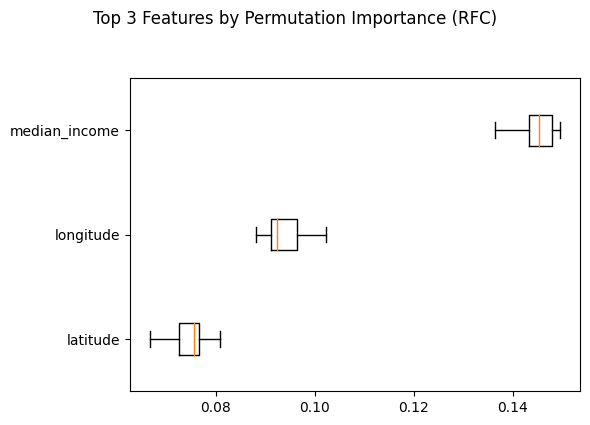

In [8]:
# permutation importance is on X_test

# Initialize the RandomForestClassifier
rfclass = RandomForestClassifier(random_state=3133252)

# Train the model on the resampled training data
model = rfclass.fit(X_train_resampled, y_train_resampled)

# Compute permutation importance with 15 repeats
result = permutation_importance(rfclass, X_test, y_test, n_repeats=15, random_state=3133252)
perm_sorted_idx = result.importances_mean.argsort()[-3:]

# Plot the top 3 features as a boxplot
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X.columns[perm_sorted_idx])
fig.suptitle('Top 3 Features by Permutation Importance (RFC)', y=1.05)
fig.tight_layout()
plt.show()

## Partial Dependence

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


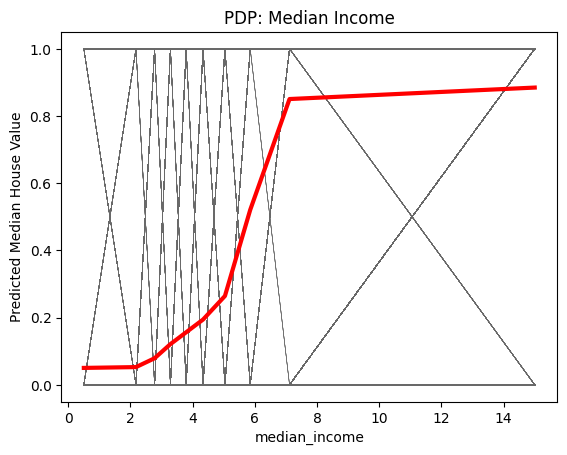

In [9]:
# partial dependence is on X_train


# Assuming X_train_resampled is your DataFrame and 'median_income' is the feature of interest
tmpdf = ice(data=X_train_resampled, column='median_income', predict=rfclass.predict, num_grid_points=10)

# Plot ICE for 'Median Income'
ice_plot(tmpdf, c='dimgray', linewidth=0.3,
                  plot_pdp=True,
         pdp_kwargs={'linewidth': 3, 'color':'red'})
plt.title('PDP: Median Income')
plt.ylabel('Predicted Median House Value')
plt.xlabel('median_income');
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


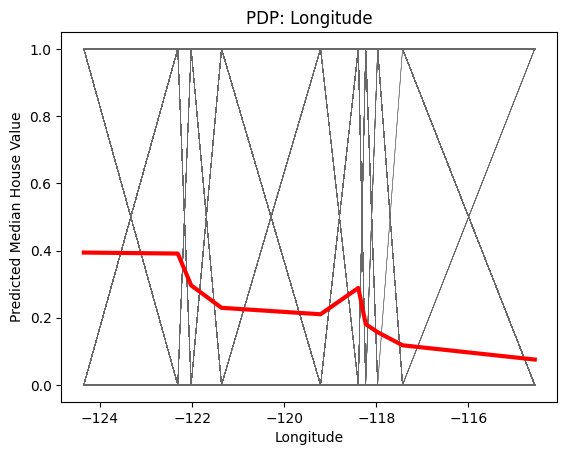

In [10]:
# Plot ICE for 'Longitude'
tmpdf = ice(data=X_train_resampled, column='longitude', predict=rfclass.predict, num_grid_points=10)
ice_plot(tmpdf, c='dimgray', linewidth=0.3,
                  plot_pdp=True,
         pdp_kwargs={'linewidth': 3, 'color':'red'})
plt.title('PDP: Longitude')
plt.ylabel('Predicted Median House Value')
plt.xlabel('Longitude');
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


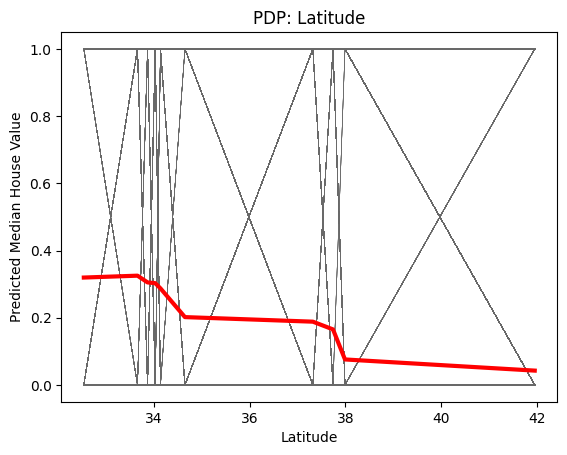

In [11]:
# Plot ICE for 'Latitude'
tmpdf = ice(data=X_train_resampled, column='latitude', predict=rfclass.predict, num_grid_points=10)
ice_plot(tmpdf, c='dimgray', linewidth=0.3,
                  plot_pdp=True,
         pdp_kwargs={'linewidth': 3, 'color':'red'})
plt.title('PDP: Latitude')
plt.ylabel('Predicted Median House Value')
plt.xlabel('Latitude');
plt.show()

# Conclusions

* Oversampling balanced the dataset from class 0 and 1 being 10197 and 3403 respectively to 10197 and 10197 for both classes.
* Train confusion matrix shows the perfect distribution where the model is able to capture all true positives and true negatives.
* Test confusion matrix is able to capture maximum of the datapoints correctly. where it's able to capture 2426 True Positives and 656 True Negatives. Out of 3400, the confusion matrxi shows it's able to capture total of 3082 True negatives and true positives.
* The classification report shows the test classification has the accuracy of 0.91.
* According to the box-plot of Permutation Importance, Top 3 features for my Random Forest Classification model are median_income, latitude, and longitude, with median_income being the top feature and latitude and longitude being 2nd and 3rd respectively.
* Partial Dependence Plot:
  * **Median Income:** Median house value shows the upward trend with a huge spike which starts around 5 median_income with predicted median_house_value of 0.2 and it goes up till 0.9 at median_income of 7 and then it shows slight upward trend from there as well.
  * **Longitude:** As the longitude is increasing, the predicted value is decreasing with a spike at around -119 to -118 and then sudden decrease from -118 onwards.
  * **Latitude:** As the latitude is increasing, the predicted value is going down with sudden downward slope between 37-38 creating a step-wise structure in the plot.